# Assignment 3

*Part of the course:
Machine Learning (code: INFOB3ML), fall 2021, Utrecht University*

Total points: 9 (+ 1 for free)

Submit one ipynb file per pair.

**Before you submit, click Kernel > Restart & Run All to make sure you submit a working version of your code!**

## General
This is a largely freeform project, where you will implement and use several machine learning methods you've seen during this course, and write a report on your results.

In [96]:
import numpy
import numpy as np
import random
import scipy
import copy
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm

import cProfile
import sklearn.model_selection
from scipy.spatial import distance
from itertools import cycle

## Implement K-means

**Task:** *(2 points)* Complete the function below to carry out the K-means clustering algorithm.

The function takes two arguments:

* A data matrix `X`. Your function should be able to handle any number of data points (rows) and any number of real-valued features (columns);

* The number of clusters `K`.

The function should return two things:

* A numpy array `mu` with the cluster centroids. It should have `K` rows, each describing of the `K` clusters, and a number of columns equal to the number of features;

* A list (or numpy array if you prefer) `assigned_to`, containing one element for each data point. The value of the element is the index of the cluster that data point is assigned to. The indices should correspond to those of the rows of `mu`, so they should be between `0` and `K-1`.

There are different ways to initialise the algorithm, and you can pick one you like. This step should involve some randomness, so that if you run the algorithm repeatedly, you have a chance of getting a different clustering every time.

In [99]:
def get_closest_centroids(X, mu, return_D, debug):
    """
    We first make a matrix, with in it for each centroid a matrix, that holds, for each datapoint,
    the distance to each dimension of the centroid of the current cluster. An example for N=3, 4 features, k=2, would be:
    [
     [ [1, 1.5, 2, 2.5],
       [2, 2.5, 3, 3.5],
       [3, 3.5, 4, 4.5] ],

     [ [1, 2, 3, 4], <- datapoint_1 has a distance of 1+2+3+4=10 to the second centroid
       [3, 4, 5, 6],
       [6, 7, 8, 9] ]
    ]
    """
    distances_all_dims = np.sqrt(((X - mu[:, np.newaxis])**2))

    # Now for each datapoint, we sum its distance to each centroid-dimension, and ask for the argmin
    distances = distances_all_dims.sum(axis=2)

    # Now we can return a Nx1-matrix with the closest centroids.
    return numpy.argmin(distances, axis=0)

def move_centroids(datapoints, assigned_to, old_centroids, debug):
    # For each cluster, the mean of its datapoints is the new centroid
    new_centroids = []

    for k in range(old_centroids.shape[0]): # This range is just the number of clusters
        cluster_k = datapoints[assigned_to==k]

        # Check if the cluster isn't empty, then calculate new centroid. If it is, keep the old centroid.
        if (cluster_k.size != 0):
            new_centroids.append(cluster_k.mean(axis=0))
        else:
            new_centroids.append(old_centroids[k])

    return numpy.array(new_centroids) # Return k*dims-array of centroid coordinates

def calculate_D(X, mu, assigned_to):
    """
    For each cluster, calculate the sum of squared distances from the datapoint to the mean (= total_D).
    Takes in the data as numpy array (matrix), mu as 1*k array of 1*n_feature means, and assigned to as an 1 x N array.
    Returns the value of D.
    """
    total_D = 0

    for k, mu_k in enumerate(mu): # Calculate D per cluster
        cluster_k = X[assigned_to == k] # Subset the current cluster

        curr_D = np.sum((cluster_k - mu_k)**2)
        total_D += curr_D

    return total_D

def k_means_vec(X, k, return_D=False, debug=False):
    # Initialize centroid & cluster vector
    mu = X[numpy.random.choice(X.shape[0], k, replace=False), :] # Choose k random datapoints as starting means
    pre_mu = numpy.zeros_like(mu) # Make an empty container to copy mu
    closest_centroids = numpy.full((X.shape[0],), 0) # Container for the centroids

    if debug:
        print(f"mu={mu} \npre_mu={pre_mu} \nclosest_centroids={closest_centroids}\n")

    count=0

    while not numpy.array_equal(mu, pre_mu):
        # First save the current mu, such that we can compare it again, after it has changed
        pre_mu = copy.deepcopy(mu)

        if debug:
            print("iter:",count); count+=1;

        # Calculate for each datapoint, its closest centroid
        assigned_to = get_closest_centroids(X, mu, return_D, debug)

        if debug:
            print(f"assigned_to={assigned_to}, with shape {assigned_to.shape}")

        # Now we update the centroids, by taking the mean for the updated closests points
        mu = move_centroids(X, assigned_to, mu, debug)

    # Return results
    if return_D:
        return mu, assigned_to, calculate_D(X, mu, assigned_to)
    return mu, assigned_to

To test if your function is working well, you can run it on the following simulated data.

mu [[ 1.14999481  3.12902341]
 [-0.06448773  0.05613906]] 

z [1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1] 

D 188.25156844613286 



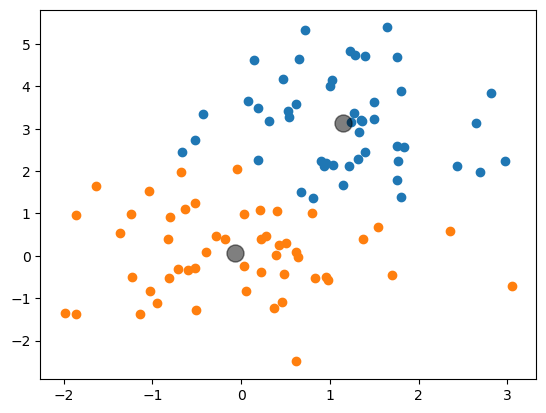

In [100]:
X_simulated = numpy.random.normal(0, 1, (100, 2))
X_simulated[50:,:] += [1, 3] # Move points 50 through 99 to be centred on (1,3).
example_k = 2

mu, z, D = k_means_vec(X_simulated, example_k, return_D = True, debug=False)
print("mu",mu,"\n")
print("z", z, "\n")
print("D", D, "\n")

for k in range(example_k):
    plt.scatter(X_simulated[z == k, 0], X_simulated[z == k, 1], cmap='viridis')
    plt.scatter(mu[k, 0], mu[k, 1], c = 'black', s = 150, alpha = 0.5)
plt.show()

## Data preprocessing

**Task: Pick a dataset.** *(1 point)* Find a dataset that you find interesting to analyse. Some properties:

* It should be a supervised learning problem, either regression or classification (in other words: there should be some label that must be predicted based on features, and this label can be real-valued or discrete);

* It shouldn't be too big, so the computation times don't become annoying;

* It should have say 5~10 numeric features. A feature is called "numeric" if its values really represent numbers. Sometimes non-numeric information is encoded as numbers (e.g., yes=1, no=2, not sure=3). Then doing things like computing differences or averages of those numbers doesn't really mean anything. So such features are not considered numeric. (If your data also has non-numeric features, we'll ignore those.)

Example website with many data sets: http://archive.ics.uci.edu/ml/index.php

Write code to load your dataset from a file in the same folder as your notebook. (Include that file with your notebook when submitting your assignment.)

If your data includes non-numeric features, have your code remove those after loading.

In the text cell below, give a (very brief) description of the data: what is it about, what does the label mean and what are its possible values, how many numeric features does it have, what is the source of your data?

In [5]:
data_set = pd.read_csv(r'winequality-white.csv', sep=';', header = 0)
data_set.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [6]:
# We save and then delete the wine quality feature. This will be effectively used as "label" later on.
label_set = data_set['quality']
data_set1 = data_set.drop(['quality'], axis = 1)

In [7]:
# import pandas_profiling
# pandas_profiling.ProfileReport(data_set_clean)

*Your description of the data here*

## To do

In some datasets, the different features may represent completely different things, each measured in their own way. If one feature has very large values while another has only very small ones, this may have an impact on the results of certain machine learning algorithms. K-means for example measures distances between data points, but if one feature has values in the thousands and another has values between 0 and 1, the second feature would effectively end up being ignored. This is often undesirable. Some data preprocessing is the necessary to avoid this effect.

**Task: Normalise the dataset.** *(0.5 point)* Divide each numerical feature by its standard deviation. By doing this, each numeric feature in the normalised dataset will have variance 1. As a result, all features will now live in a comparable range, and all will play a role in distance computations.

**Explaination**  
Before normalising, we realise we might encounter the issue of missing/NaN values. We choose not to delete these rows, as deleting data is generally frowned upon, and we saw no reason to throw away the rest of the rows. Instead, we choose to do an estimate/approximation, by filling all NaN values with the average of the column. We do this before normalising, because we want the "interpolated" datapoints to be taken into account for the standard deviation.

In [8]:
data_set.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

But, our data doesn't contain any NaN values! 

In [9]:
# If nan's would exist, we could use the following: data_set1.fillna(data_set1.mean())

# Now, we may normalise the data by dividing each feature by its standard deviation
data_set_norm = data_set1 / data_set1.std()
data_set_norm.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,8.295134,2.678716,2.974720,4.081184,2.059688,2.645948,4.000182,334.681094,19.867471,3.943016,7.150864
1,7.465621,2.976351,2.809458,0.315454,2.242771,0.823184,3.106024,332.340667,21.854218,4.293506,7.719682
2,9.598655,2.777928,3.305244,1.360395,2.288542,1.763965,2.282457,332.708449,21.589318,3.855394,8.207241
3,8.532138,2.281869,2.644195,1.675848,2.654709,2.763546,4.376670,332.875622,21.125744,3.504903,8.044722
4,8.532138,2.281869,2.644195,1.675848,2.654709,2.763546,4.376670,332.875622,21.125744,3.504903,8.044722


We also get the z-score normalised dataset, which is rather similar to dividing by the standard deviation, but in addition we also subtract the mean of each column before dividing.

In [92]:
from scipy.stats import zscore
data_set_zscore = data_set1.apply(zscore)
#data_set_zscore.head()

## Explore your data using unsupervised learning

Your goal with the data is to solve a supervised learning problem. But unsupervised learning can be a useful first step: it can help to give you a better idea of what the data "looks like", and it can help to select relevant features for use in a later supervised learning step.

In these steps, only use the features, not the label.

**Task: Explore the data using K-means.** *(1.5 points)* Try out a range of values for `K`. Make a plot similar to the one in Figure 6.3 in the book. The discuss the question: what seems to be a reasonable number of clusters for your data?

Now we explore how different values of K influence the performance of the clustering. We do this by plotting $\log D$ against $k$, for 50 iterations of the algorithm (thus also 50 random initialisations).

In [12]:
def k_means_logD_runner(X: 'data', k_range: 'range-object', n_runs: 'runs per k', progress_debug=True, debug=False
                        ) -> '{k1:[logD1, logD2,..], k2:[]...}':

    D_dict = {} # This dict will contain for each k, the values of D for all 50 runs. 

    if progress_debug:
        highest_k = max(k_range)

    for k in k_range:
        if progress_debug:
            print(f"Calculation for k={k} out of k={highest_k} started.")

        D_dict[k] = [] # Initialise a list which will contain a n_runs amount of logD-values

        for run_i in range(n_runs): # Run K-means 50 times
            mu, assigned_to, curr_D = k_means_vec(data_set_norm_numpy, k, return_D=True, debug=False)
            D_dict[k].append(math.log(curr_D)) # We want to store the log of this value

    return D_dict

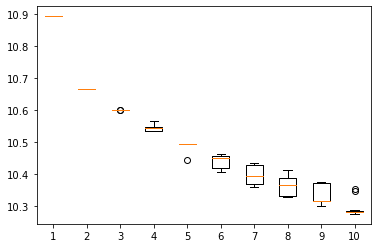

In [13]:
# Convert to numpy array to make it work with the K-means function
data_set_norm_numpy = data_set_norm.to_numpy()

# Run algorithm and obtain logD values
D_dict = k_means_logD_runner(data_set_norm_numpy, range(1,11), n_runs=10, progress_debug=False, debug=False)

# Plot the result of each run as boxplot
fig2, ax2 = plt.subplots()
ax2.boxplot(list(D_dict.values()), labels=list(D_dict.keys()));

**Choosing k**  
Now we can choose a value of of k that we find most suitable for the data. We do so with the "elbow method"; pick the k value where the plot displays a nick/bend/elbow. This is rather open for intepretation as the plot does not have such a clear elbow. In fact, the range from 2 to 6 is almost linear. An interpretation of this is that there is no point where adding an extra cluster adds significatly less clustering performance than before. Extra clusters always make the results "a bit" better. That being said, we choose k=6, for two reasons. First because after k=6 the linearity clearly disappears. Second, k=6 is the first value for k when the logD calculation become more of a precise estimate around the mean; those before had a lot of outliers. Additionally, there is a point to be made about the distribution of the actual labels. The actual given marks range from 3 to 9; that's 7 marks. There however are very few 3's anyway (or, very few 9s, depending on how you look at it), so we could lump those in. So, k=6 could for example represent grade 3/4 and below, 5 through 8, and 9 and up. Or we could choose k=7; one could well be as good as the other. (I say this because I feel like there is some degree of arbitrainess involved in picking the value for k no matter how you look at it.)

**Evaluating clusters for chosen k**  


In [34]:
all_assigned_to = [] # Will contain n_runs numpy arrays with the assigned clusters
total_quality_counts = {k : np.array([0.0 for _ in range(1, 11)]) for k in range(6)}  # Will contain per cluster, a list with counts of each quality grade. E.g. {1: [0,0,3,5,10,6,3,1,0], ...}

# Run k-means
mu, assigned_to = k_means_vec(data_set_norm_numpy, k=6, return_D=False)

for k in range(6): # For each cluster,
    cluster_labels = label_set[assigned_to==k] # subset the data,
    curr_quality_counts = np.bincount(cluster_labels, minlength = 11) # Get counts of each grade (0 through 10, works for pos ints
    curr_quality_counts = curr_quality_counts[1:] # Since this counts 0 as a grade, and that's not possible, we splice it off
    curr_quality_counts = curr_quality_counts / len(label_set) # Now we calculate the fraction

    total_quality_counts[k] += curr_quality_counts

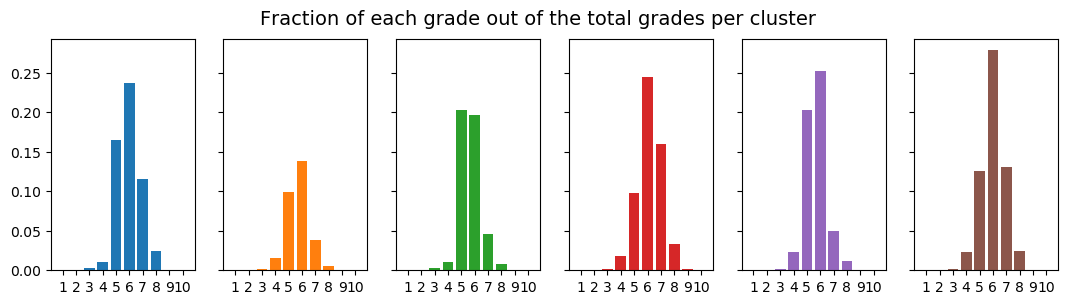

In [88]:
fig_keval, axs_keval = plt.subplots(nrows=1, ncols=6, figsize=(13,3), sharex=True, sharey=True)
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = cycle(prop_cycle.by_key()['color'])

for k in range(6):
    axs_keval[k].bar(x=[i for i in range(10)], height=(total_quality_counts[k]), # Plot the average count, as a fraction of the total
                    tick_label=[str(i) for i in range(1,11)], color=next(colors)) # Force cycling to the k-th color of the (default) cmap

fig_keval.suptitle("Fraction of each grade out of the total grades per cluster", fontsize=14)
fig_keval.show()
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

**Conclusions of K-means clustering**  
to do

In [16]:
# K_un = 5
# mu_un, z_un = K_means_debug(data_set_norm_numpy, K_un)

# for k in range(K_un):
#     plt.scatter(data_set_norm_numpy[z_un == k, 0], data_set_norm_numpy[z_un == k, 1], cmap='viridis', alpha=0.4)
#     plt.scatter(mu_un[k, 0], mu_un[k, 1], c = 'black', s = 150, alpha = 0.9)
# plt.xlim([0,8])
# plt.ylim([0,6])
# plt.show()

NameError: name 'z_un' is not defined

<Figure size 640x480 with 0 Axes>

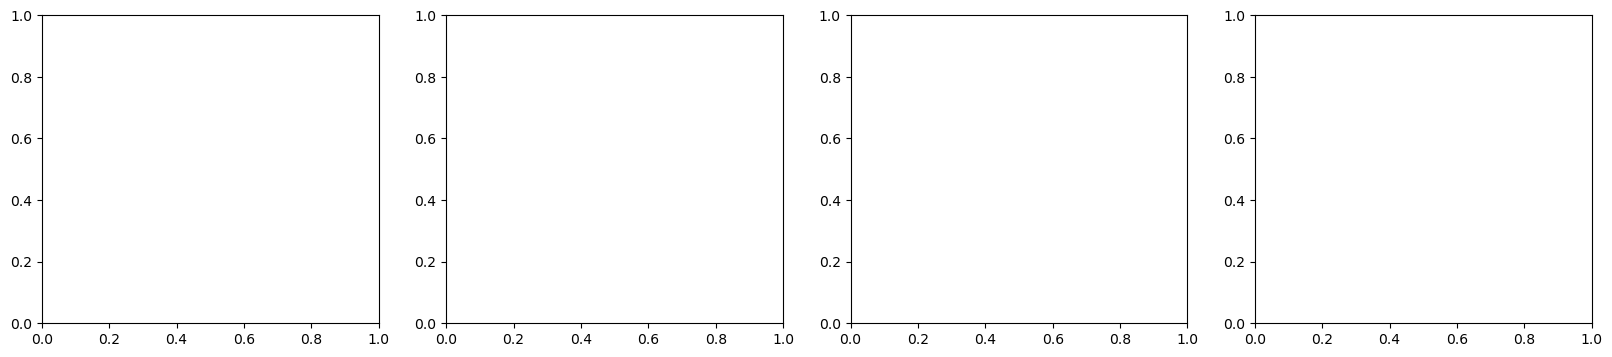

In [17]:
f = plt.figure();
f, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,4), sharex=False, sharey = False);

tags = list(data_set_norm.columns)
styles = ["o", "s", "D", "*", "P", "p"]

K_everything = 4
for plot_xidx, f_pair in enumerate([1,2,3,4]): # We have 5 features, and now plot the first against the othre 4
    for k in range(K_everything):
        colors = plt.rcParams["axes.prop_cycle"].by_key()["color"] # Get the color the cmap is currently one

        axes[plot_xidx].scatter(data_set_norm_numpy[z_un == k, 0], data_set_norm_numpy[z_un == k, f_pair],
                                cmap='viridis', marker = styles[k], alpha = 0.2,
                                zorder = -1)
    
        axes[plot_xidx].scatter(mu_un[k, 0], mu_un[k, f_pair], s = 150, 
                                c = colors[k], edgecolors='black', marker = styles[k], alpha = 1, # Use the previously saved color
                                zorder = 1)
        # Add axis labels (obtained from the dataframe headers)
        axes[plot_xidx].set_xlabel(tags[0])
        axes[plot_xidx].set_ylabel(tags[f_pair]);

In [0]:
#cProfile.run('K_means_debug(data_set_norm.to_numpy(), K_un)')

**Task: Visualise the data using PCA.** *(1 point)* You don't need to implement PCA yourself, you can use a package for this like `sklearn.decomposition.PCA`. Run PCA with 2 components, so that you get a 2-dimensional "summary" of your data. Plot this version of your data.

**Running PCA**  
First, we will run PCA with 2 principal components, like the assignment says. Afterwards, we will select the optimum number of principal components, which we can use as a (perhaps) better performing option for the supervised learning part.

In [23]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [24]:
# We delete the wine quality feature. This will be effectively used as "label" later on.
y = data_set['quality']
data_set_pca = data_set.drop(['quality'], axis = 1)

# Standardizing the features
data_set_pca = StandardScaler().fit_transform(data_set_pca)

# Running the PCA
pca2 = PCA(n_components = 2)
data_set_2D = pca2.fit_transform(data_set_pca)

**Visualising PCA**  
Now we visualise the results of the PCA.

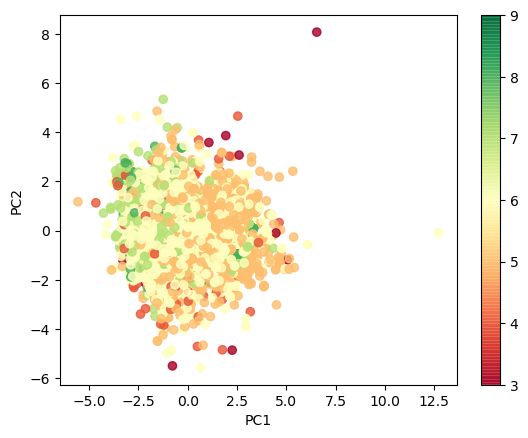

In [63]:
plt.scatter(data_set_2D[:,0], data_set_2D[:,1], alpha=0.8, c=y, cmap='RdYlGn')

cbar = plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2');

By visual inspection, this does not look a whole lot better than before. Reducing dimensionality of the data does not seem to have given rise to any "structure" in terms of the relationship between the data (principal components) and the labels. We can additionally run k-means clustering on the PCA'd data as a means of trying to visualise the above plot in terms of how it can be clustered.

**Running clustering on PCA data**

In [89]:
total_quality_counts_2d = {k : np.array([0.0 for _ in range(1, 11)]) for k in range(6)}  # Will contain per cluster, a list with counts of each quality grade. E.g. {1: [0,0,3,5,10,6,3,1,0], ...}

# Run k-means
mu_pca, assigned_to_pca = k_means_vec(data_set_2D, k=6, return_D=False)

for k in range(6): # For each cluster,
    cluster_labels = label_set[assigned_to_pca==k] # subset the data,
    curr_quality_counts = np.bincount(cluster_labels, minlength = 11) # Get counts of each grade (0 through 10, works for pos ints
    curr_quality_counts = curr_quality_counts[1:] # Since this counts 0 as a grade, and that's not possible, we splice it off
    curr_quality_counts = curr_quality_counts / len(label_set) # Now we calculate the fraction

    total_quality_counts_2d[k] += curr_quality_counts

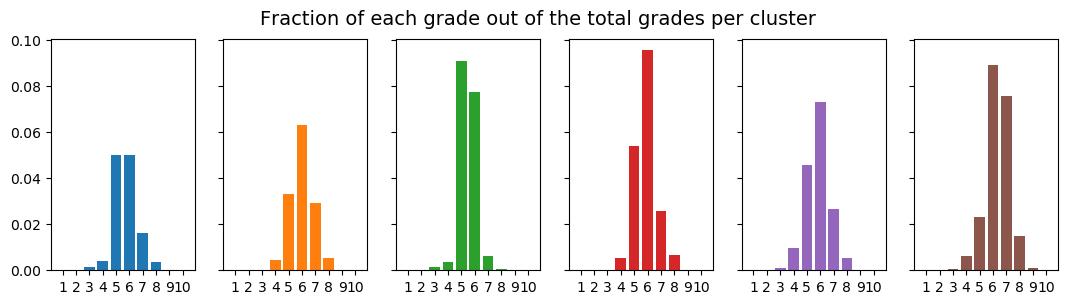

In [91]:
fig_pcaeval, axs_pcaeval = plt.subplots(nrows=1, ncols=6, figsize=(13,3), sharex=True, sharey=True)
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = cycle(prop_cycle.by_key()['color'])

for k in range(6):
    axs_pcaeval[k].bar(x=[i for i in range(10)], height=(total_quality_counts_2d[k]), # Plot the average count, as a fraction of the total
                    tick_label=[str(i) for i in range(1,11)], color=next(colors)) # Force cycling to the k-th color of the (default) cmap

fig_pcaeval.suptitle("Fraction of each grade out of the total grades per cluster", fontsize=14)
fig_pcaeval.show()
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

We see comparable results as before. The clusters seem not to relate to the labels in a meaningful sense. We could at this point make a loadings plot to see how each feature contributes to each of the PC's, but, what would that tell us? If we inspect the scatterplot, there's no way of relating (for example) a high PC2 score and low PC1 score to a certain wine quality label. After all, no useful clusters were found, so we can't relate the PC-coordinates of the cluster to which features contributed most to the variance of the points in that cluster.

**Varying number of PCs**  
As said before, we now run PCA with a varying amount of components, to select the optimum amount of PCs. The criterion for this selection is the (added) amount of explained variance per principle component.

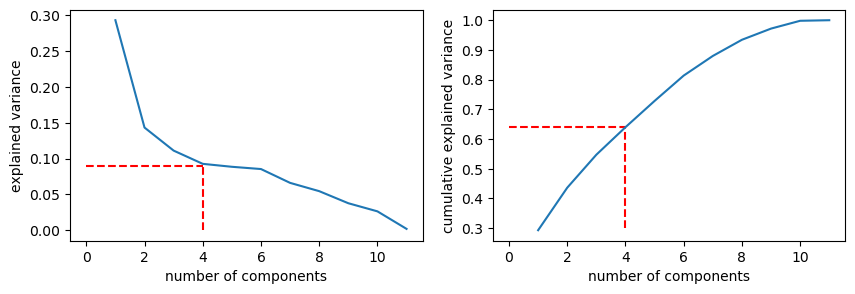

In [71]:
# Run PCA with varying amount of components
performance_pca = PCA().fit(data_set_pca)
comparisons = range(1, performance_pca.n_components_ + 1)

# Display percentage of additional explained variance per component
expl_var = performance_pca.explained_variance_ratio_

pca_fig1, (pca_ax1, pca_ax2) = plt.subplots(1, 2, figsize=(10,3))
pca_ax1.plot(comparisons, expl_var)
pca_ax1.vlines(4, 0.00, 0.093, color='red', linestyles='dashed')
pca_ax1.hlines(0.09, 0, 4.01, color='red', linestyles='dashed')
pca_ax1.set_xlabel('number of components')
pca_ax1.set_ylabel('explained variance')
pca_fig1.show()

# Display cumulative explained variance
cumul_var = np.cumsum(performance_pca.explained_variance_ratio_)

#pca_fig2, pca_ax2 = plt.subplots()
pca_ax2.plot(comparisons, cumul_var)
var_at_4=0.64
pca_ax2.vlines(4, 0.3, var_at_4, color='red', linestyles='dashed')
pca_ax2.hlines(var_at_4, 0, 4.01, color='red', linestyles='dashed')
pca_ax2.set_xlabel('number of components')
pca_ax2.set_ylabel('cumulative explained variance')
pca_fig2.show()

In [112]:
# Running the PCA with 4 components.
pca4 = PCA(n_components = 4)
data_set_4D = pca4.fit_transform(data_set_pca)

# of ja misschien toch wel overzichtelijker
final_data_set = pd.DataFrame(data = data_set_4D, columns = ['PCA 1','PCA 2','PCA 3','PCA 4'])
final_data_set = pd.concat([final_data_set, data_set[['quality']]], axis = 1)
final_data_set.head()

,PCA 1,PCA 2,PCA 3,PCA 4,quality
0,3.676944,-0.545233,-0.930422,-1.135374,6
1,-0.644588,0.430770,-0.356331,0.999117,6
2,0.155291,-1.189800,-0.017532,0.270219,6
3,1.455374,0.099680,-0.001956,-0.423022,6
4,1.455374,0.099680,-0.001956,-0.423022,6


**This is the end of the PCA stuff I think Dirk**

In [0]:
# Plot the feautures in along the first two principle components of the model
f, (axes)=plt.subplots(figsize = (23, 15), nrows=1, ncols=1)

n_features = 10
for i in range(n_features):
    plt.arrow(0, 0, 
              performance_pca.components_[0,i], 
              performance_pca.components_[1,i],
              color = 'r',alpha = 0.5, 
              head_width=0.02, overhang=0.5)
    plt.text(performance_pca.components_[0,i]*1.3,
            performance_pca.components_[1,i]*1.3,
            data_set_pca.columns[i])
    
plt.xlim(-0.5,0.5)
plt.ylim(-0.5,0.5)
plt.xlabel(f"PC1 {100*performance_pca.explained_variance_ratio_[0]:.2f}% of variance", size = 12)
plt.ylabel(f"PC2 {100*performance_pca.explained_variance_ratio_[1]:.2f}% of variance", size = 12)
plt.title("First half of features projected onto PC1 and PC2", size = 16);

In [0]:
"""
def load_dataset():
    # load the data set
    data_set = pd.read_csv(r'winequality-white.csv', sep=';', header = 0) 
    # treat Nan values
    data_set.fillna(data_set.mean())
    # split label from data
    dataX, labelY = (data_set.drop(['quality'], axis = 1), data_set['quality'])
    return (dataX, labelY)

data_set1.fillna(data_set1.mean())

def standardize(dataX):
    # standardize the data set
    scaler = StandardScaler() # scaler = MinMaxScaler() scaler = MaxAbsScaler()
    dataX = scaler.fit_transform(dataX)
    #dataX_scl = dataX / dataX.std() # Thijs approach
    # rescale the label set
    # label_set = label_set-3
    return dataX

# load train and test dataset
def construct_datasets(train, label, model_type):
    # construct test and training set
    trainX, testX, trainY, testY = train_test_split(
        train.to_numpy(), 
        label.to_numpy(), 
        test_size=0.1, 
        shuffle=True)
    
    
    if model_type == 'MLP' or model_type == 'DCN': 
        # one hot encode target values
        trainY = to_categorical(trainY, num_classes=len(np.unique(label)))
        testY = to_categorical(testY, num_classes=len(np.unique(label)))
        if model_type == 'DCN': 
        trainX = trainX.reshape((trainX.shape[0], 12, 1))
        testX = testX.reshape((testX.shape[0], 12, 1))
    

    return trainX, trainY, testX, testY
"""

In [0]:
"""
# standardize the data set
scaler = StandardScaler()
data_set_stand = scaler.fit_transform(data_set)
data_set_norm = data_set1 / data_set1.std() # Thijs approach
"""

In [0]:
expl_var = np.cumsum(pca.explained_variance_ratio_)
plt.plot(comps, expl_var)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [0]:
# 2 component PCA
pca2 = PCA(n_components=2)
principalComponents = pca2.fit_transform(x) # Thijs approach: data_set_norm; or data_set_stand

principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, data_set[['quality']]], axis = 1)
finalDf.head()

In [0]:
# visualization of 2 component PCA
plt.figure(figsize=(10,10))
plt.scatter(finalDf['principal component 1'],finalDf['principal component 2'],c=finalDf['quality'],cmap='prism', s =5)
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.xlim(-5, 5)
plt.ylim(-4, 6)
plt.show()

In [0]:
# 3 component PCA
from mpl_toolkits.mplot3d import Axes3D

pca3 = PCA(n_components=3)
principalComponents = pca3.fit_transform(x) # Thijs approach: data_set_norm; or data_set_stand

principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])

finalDf = pd.concat([principalDf, data_set[['quality']]], axis = 1)
finalDf.head()

In [0]:
# visualization of 3 component PCA
fig = plt.figure(figsize=(12,12))
axes = Axes3D(fig)
axes.set_title('PCA Representation', size=14)
axes.set_xlabel('PC1')
axes.set_ylabel('PC2')
axes.set_zlabel('PC3')

axes.scatter(finalDf['principal component 1'],finalDf['principal component 2'],finalDf['principal component 3'],c=finalDf['quality'], cmap = 'prism', s=10);

In [0]:
# Hopeless attempt to check whether PCA can solve the problem: implementing a simple logistic regression for 2 component PCA

In [0]:


### Standardizing the Dataset
#scaler = StandardScaler()

# Fit on training set only.
#scaler.fit(X_train)

# Apply transform to both the training set and the test set.
#X_train_pca = scaler.transform(X_train)
#X_test_pca = scaler.transform(X_test)

In [165]:
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

#fit logistic regression to the data set with PCA
logisticRegr = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=0.001, verbose =1, n_jobs=-1)
logisticRegr.fit(X_train,y_train) # X_train_pca
    
model_eval = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=1)
score = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=model_eval, n_jobs=-1)
print('Mean Accuracy: {:.3f}%, Standard deviation: {:.3f}%'.format(mean(score)*100, std(score)*100))

y_train_hat =logisticRegr.predict(X_train) # X_train_pca
train_accuracy = accuracy_score(y_train, y_train_hat)*100
print('"Accuracy for Training dataset with PCA is: %.4f %%' % train_accuracy)

NameError: name 'X_train' is not defined

In [0]:
y_test_hat=logisticRegr.predict(X_test) # X_test_pca
test_accuracy=accuracy_score(y_test,y_test_hat)*100
test_accuracy
print("Accuracy for Testing dataset with PCA is : {:.3f}%".format(test_accuracy) )

## Supervised learning

**Task: Train and compare supervised learning methods.** *(3 points)* For the final part of this assignment, you'll try two different regression or classification methods on your dataset. You don't need to implement these yourself, you can use existing packages. You should also experiment with different settings of those methods, like how many features they get to see, or what the value of a regularisation parameter is. Your goal is to select a method that you believe will give the best results where more data from the same source come in.

Write a report on your findings.

In your report, you should specifically pay attention to the following:

* Which two supervised learning methods will you use? Why did you pick these two? (You can pick a method that hasn't been discussed (yet) during the course, if you want.)

* When comparing the performance of different alternatives, keep in mind that the error on training data is not a good estimate of the error on unseen data. To get a measure for the latter, you can for example use a form of cross-validation.

* What method and settings do you recommend? What choices (of method, of various settings) make the biggest difference for the performance on new data?

In [151]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers

import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adadelta

ModuleNotFoundError: No module named 'tensorflow'

In [166]:
from numpy import mean
from numpy import std
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

#fit logistic regression to the data set with PCA
logisticRegr = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=0.001, verbose =1, n_jobs=-1)
logisticRegr.fit(X_train,y_train) # X_train_pca
    
model_eval = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=1)
score = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=model_eval, n_jobs=-1)
print('Mean Accuracy: {:.3f}%, Standard deviation: {:.3f}%'.format(mean(score)*100, std(score)*100))

y_train_hat =logisticRegr.predict(X_train) # X_train_pca
train_accuracy = accuracy_score(y_train, y_train_hat)*100
print('"Accuracy for Training dataset with PCA is: %.4f %%' % train_accuracy)

y_test_hat=logisticRegr.predict(X_test) # X_test_pca
test_accuracy=accuracy_score(y_test,y_test_hat)*100
test_accuracy
print("Accuracy for Testing dataset with PCA is : {:.3f}%".format(test_accuracy) )


# We delete the wine quality feature. This will be effectively used as "label" later on.
y = data_set['quality']
data_set_pca = data_set.drop(['quality'], axis = 1)

# Standardizing the features



NameError: name 'X_train' is not defined

In [187]:
from numpy import mean
from numpy import std
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

def define_LogReg_model():
    #fit logistic regression to the data set with PCA
    model = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=0.001, n_jobs=-1) 
    return model
    
def evaluate_logreg_model(model, trainX, trainY, testX, testY):
    """
    # define the model evaluation procedure
    model_eval = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=1)
    # evaluate the model and collect the scores
    score = cross_val_score(model, trainings_set, label_set, scoring='accuracy', cv=model_eval, n_jobs=-1)
    # report the model performance
    print('Mean Accuracy: %.3f (%.3f)' % (mean(score), std(score)))
    """
    model.fit(trainX,trainY)
    model_eval = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=1)
    score = cross_val_score(model, trainX, trainY, scoring='accuracy', cv=model_eval, n_jobs=-1)
    print('Mean Accuracy: {:.3f}%, Standard deviation: {:.3f}%'.format(mean(score)*100, std(score)*100))

    trainY_hat =model.predict(trainX) # X_train_pca
    train_accuracy = accuracy_score(trainY, trainY_hat)*100
    print('Accuracy for Training dataset with PCA is: %.4f %%' % train_accuracy)

    testY_hat=model.predict(testX) # X_test_pca
    test_accuracy=accuracy_score(testY,testY_hat)*100
    test_accuracy
    print('Accuracy for Testing dataset with PCA is : {:.3f}%'.format(test_accuracy) )

def run_multino_logreg():
    # define dataset
    #traings_set, label_set = load_dataset()
    trainings_set, label_set = (final_data_set.drop(['quality'], axis = 1), final_data_set['quality'])
    # prepocess data
    trainings_set_stand, label_set_resc = preprocess_data(trainings_set, label_set)
    # define the multinomial logistic regression model
    model_type = 2
    trainX, trainY, testX, testY = construct_datasets(trainings_set_stand, label_set_resc, model_type)
    # define LogReg model
    model = define_LogReg_model()
    # evaluate the multinomial logistic regression model
    evaluate_logreg_model(model, trainX, trainY, testX, testY)

In [188]:
#run_multino_logreg()
run_multino_logreg()

Mean Accuracy: 44.995%, Standard deviation: 0.073%
Accuracy for Training dataset with PCA is: 45.7577 %
Accuracy for Testing dataset with PCA is : 46.122%


In [156]:
def load_dataset():
    # load the data set
    data_set = pd.read_csv(r'winequality-white.csv', sep=';', header = 0)  
    trainings_set, label_set = (data_set.drop(['quality'], axis = 1), data_set['quality'])
    return trainings_set, label_set

def preprocess_data(data_set, label_set):
    # standardize the trainings data
    data_set = StandardScaler().fit_transform(data_set)
    # rescale the label set
    label_set = label_set-3
    return data_set, label_set

# load train and test dataset
def construct_datasets(train, label, model_type):
    # construct test and training set
    trainX, testX, trainY, testY = train_test_split(
        train,#.to_numpy(), 
        label,#.to_numpy(), 
        test_size=0.1, 
        shuffle=True)
    
    if model_type == 1: 
        trainX = trainX.reshape((trainX.shape[0], 12, 1))
        testX = testX.reshape((testX.shape[0], 12, 1))
    
    # one hot encode target values
    #trainY = to_categorical(trainY, num_classes=len(np.unique(label)))
    #testY = to_categorical(testY, num_classes=len(np.unique(label)))
    return trainX, trainY, testX, testY

In [0]:
# define MLP model
def define_MLP_model(num_features):
    model = Sequential()
    model.add(Dense(units=128,
                    #kernel_regularizer=regularizers.l2(1e-5), 
                    #activity_regularizer=regularizers.l2(1e-5), 
                    activation='tanh', 
                    input_dim=num_features))
    model.add(Dropout(0.20))
    model.add(Dense(units=32, 
                    #kernel_regularizer=regularizers.l2(1e-5), 
                    #activity_regularizer=regularizers.l2(1e-5), 
                    activation='tanh'))
    model.add(Dropout(0.25))
    model.add(Dense(units=7, 
                    activation='softmax'))
    
    # compile model
    model.compile(optimizer=RMSprop(learning_rate = 0.003),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# define DCN model
def define_DCN_model(num_features):
    model = Sequential()
    model.add(Conv1D(32, kernel_size=(1),
             activation='tanh',
             input_shape=(num_features,1)))
    model.add(Dropout(0.20))
    model.add(Conv1D(16, kernel_size=(1),
             activation='tanh'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(units=7, 
                    activation='softmax'))
    
    # compile model
    model.compile(optimizer = RMSprop(learning_rate = 0.003),
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    return model

def predict (model, testX, testY):     
    prediction = model.predict(testX) 
    prediction = np.argmax(prediction, axis = 1)[:20] 
    label = np.argmax(testY,axis = 1)[:20] 
    print(prediction) 
    print(label)

def build_plots(history):   
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def evaluate_NN_model(trainX, trainY, testX, testY, model_type):
    # define model
    num_features = trainX.shape[1]
        
    if model_type == 0:
        model = define_MLP_model(num_features)
    else:
        model = define_DCN_model(num_features)
    model.summary()
    
    # fit model
    history = model.fit(trainX,
                        trainY, 
                        batch_size=64,
                        epochs=70,
                        verbose=1,
                        validation_split = 0.25)
    score = model.evaluate(testX, testY, verbose=1)   
    
    # list accuracy and loss all data in history
    print("Final score:", score)
    
    # model prediction of the test set
    predict(model, testX, testY)
    
    # plot training process for accuracy and loss
    build_plots(history)    

def run_NN():
    model_type = 1 #0 for MLP, 1 for DCN
    # load data
    traings_set, label_set = load_dataset()
    # prepocess data
    trainings_set_stand, label_set_resc = preprocess_data(traings_set, label_set)
    # construct training and test sets
    trainX, trainY, testX, testY = construct_datasets(trainings_set_stand, label_set_resc, model_type)
    # evaluate model
    evaluate_NN_model(X_train_pca,y_train, X_test_pca, y_test, model_type)
    #evaluate_NN_model(trainX, trainY, testX, testY, model_type)

In [0]:
# entry point, run the MLP
run_NN()

*Your report here*

    
---

<br>
<br>

**Remember:**

* **Before you submit, click Kernel > Restart & Run All to make sure you submit a working version of your code!**

* **Upload both this notebook and your data file in Blackboard**